# Mel spectrogram study

In [1]:
import sys,os,signal

import numpy as np
import musicnet

import torch
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss

from scipy import fft, fftpack
from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

from librosa.feature import melspectrogram
from librosa import mel_frequencies
from librosa.core.spectrum import _spectrogram
from librosa.core import stft
from librosa.filters import mel

root = './'

%matplotlib inline

In [2]:
x = np.load("waveform_x.np.npy")

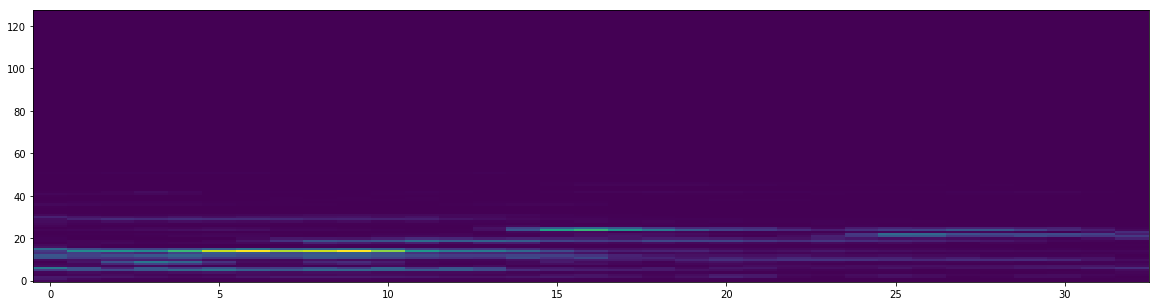

In [3]:
MelS = melspectrogram(y=x[0], sr=44100)

fig = plt.figure(figsize=(20,5))
plt.imshow(MelS,aspect='auto')
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'Final output: Mel spectrum')

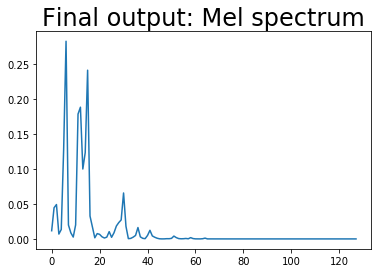

In [4]:
plt.plot(MelS[:,0])
plt.title("Final output: Mel spectrum", size=24)

# Step by step

### Getting normal spectrogram by using sfft

In [5]:
y = np.sin(2*np.pi*50*np.linspace(0,10,2048))+np.sin(2*np.pi*20*np.linspace(0,10,2048)) + np.random.normal(scale=1,size=2048)

## Method 1

In [6]:
S1, n_fft= _spectrogram(y, power=1,hop_length=512, n_fft=2048) # Center = True

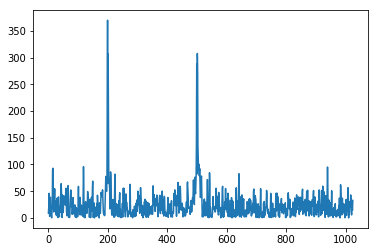

In [7]:
plt.plot(S1[:,0])

## Method 2

In [8]:
S_stft = np.abs(stft(y, hop_length=512, n_fft=2048,center=False))

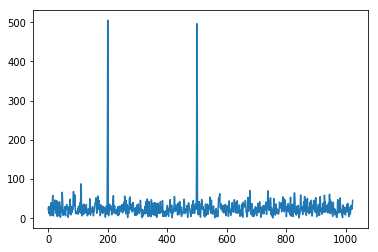

In [9]:
plt.plot(S_stft[:,0])

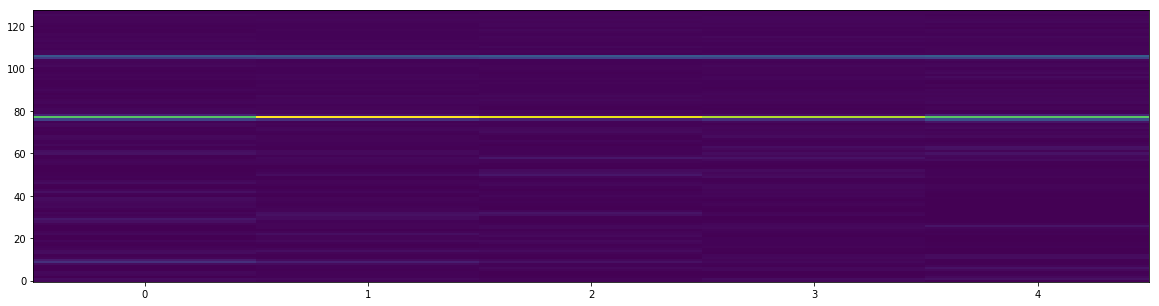

In [10]:
mel_basis = mel(44100, n_fft)

S2 = np.dot(mel_basis, S1**2)

fig = plt.figure(figsize=(20,5))
plt.imshow(S2,aspect='auto')
plt.gca().invert_yaxis()

In [15]:
mel_basis.shape

(128, 1025)

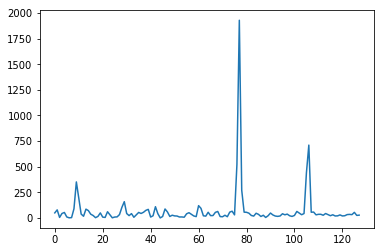

In [11]:
plt.plot(S2[:,0])

## Step by Step from FFT (Pytorch version)

In [12]:
stride = 512

In [13]:
from scipy.signal.windows import hann

In [494]:
def create_filters(d,k,low=50,high=6000):
    x = np.arange(0, d, 1)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    window_mask = hann(2048, sym=False) # same as 0.5-0.5*np.cos(2*np.pi*x/(k))
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(2*np.pi*ind/k*x)
        wcos[ind,0,:] = window_mask*np.cos(2*np.pi*ind/k*x)
    
    return wsin,wcos

In [486]:
wsin, wcos = create_filters(2048,2048)

In [487]:
wsin_var = Variable(torch.from_numpy(wsin), requires_grad=False)
wcos_var = Variable(torch.from_numpy(wcos),requires_grad=False)

In [488]:
network_input = torch.from_numpy(y)

In [489]:
network_input = network_input.reshape(1,-1).float()

In [490]:
zx = np.sqrt(conv1d(network_input[:,None,:], wsin_var, stride=stride).pow(2)+conv1d(network_input[:,None,:], wcos_var, stride=stride).pow(2))

In [491]:
pytorch_Xs = zx.cpu().numpy()

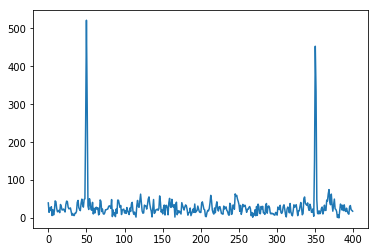

In [478]:
plt.plot(pytorch_Xs[0,150:550,0])

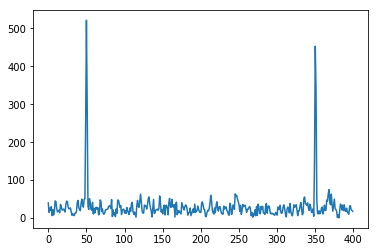

In [479]:
plt.plot(S_stft[150:550])

In [480]:
S_stft[150:550]

array([[3.98633652e+01],
       [1.50028667e+01],
       [2.62729759e+01],
       [1.96255207e+01],
       [2.98834553e+01],
       [6.44636726e+00],
       [2.17170048e+01],
       [8.06557560e+00],
       [1.95070057e+01],
       [4.51667671e+01],
       [4.28856888e+01],
       [2.54629478e+01],
       [1.64452686e+01],
       [1.72596626e+01],
       [2.03111153e+01],
       [1.42596664e+01],
       [3.56823616e+01],
       [3.07713814e+01],
       [2.13698215e+01],
       [2.14156399e+01],
       [2.37229691e+01],
       [2.05960617e+01],
       [1.59240761e+01],
       [3.54109306e+01],
       [4.46196136e+01],
       [4.35339699e+01],
       [2.89641609e+01],
       [2.43077354e+01],
       [2.47686596e+01],
       [2.67057171e+01],
       [1.70582581e+01],
       [7.18896675e+00],
       [1.19432545e+01],
       [7.19745111e+00],
       [6.50573921e+00],
       [1.26609621e+01],
       [1.27687578e+01],
       [1.75255642e+01],
       [4.15500031e+01],
       [4.64301186e+01],


In [492]:
pytorch_Xs[0,150:550,0]

array([3.98633614e+01, 1.50028543e+01, 2.62729797e+01, 1.96255264e+01,
       2.98834572e+01, 6.44637442e+00, 2.17170029e+01, 8.06558228e+00,
       1.95069962e+01, 4.51667328e+01, 4.28856583e+01, 2.54629478e+01,
       1.64452648e+01, 1.72596741e+01, 2.03111115e+01, 1.42596560e+01,
       3.56823845e+01, 3.07713661e+01, 2.13697987e+01, 2.14156380e+01,
       2.37229652e+01, 2.05960541e+01, 1.59240780e+01, 3.54109344e+01,
       4.46196022e+01, 4.35339546e+01, 2.89641361e+01, 2.43077316e+01,
       2.47686768e+01, 2.67057495e+01, 1.70582561e+01, 7.18896723e+00,
       1.19432535e+01, 7.19744587e+00, 6.50572491e+00, 1.26609592e+01,
       1.27687607e+01, 1.75255775e+01, 4.15500031e+01, 4.64301224e+01,
       2.72913933e+01, 2.25704536e+01, 1.94695797e+01, 3.92783203e+01,
       4.98925209e+01, 3.51641655e+01, 2.86910763e+01, 4.92753258e+01,
       5.07233696e+01, 2.56234070e+02, 5.21587585e+02, 2.96869263e+02,
       3.17171288e+01, 2.25316334e+01, 5.09285240e+01, 3.97474518e+01,
      

In [481]:
pytorch_Xs[0,150:550,0]

array([3.98633614e+01, 1.50028543e+01, 2.62729797e+01, 1.96255264e+01,
       2.98834572e+01, 6.44637442e+00, 2.17170029e+01, 8.06558228e+00,
       1.95069962e+01, 4.51667328e+01, 4.28856583e+01, 2.54629478e+01,
       1.64452648e+01, 1.72596741e+01, 2.03111115e+01, 1.42596560e+01,
       3.56823845e+01, 3.07713661e+01, 2.13697987e+01, 2.14156380e+01,
       2.37229652e+01, 2.05960541e+01, 1.59240780e+01, 3.54109344e+01,
       4.46196022e+01, 4.35339546e+01, 2.89641361e+01, 2.43077316e+01,
       2.47686768e+01, 2.67057495e+01, 1.70582561e+01, 7.18896723e+00,
       1.19432535e+01, 7.19744587e+00, 6.50572491e+00, 1.26609592e+01,
       1.27687607e+01, 1.75255775e+01, 4.15500031e+01, 4.64301224e+01,
       2.72913933e+01, 2.25704536e+01, 1.94695797e+01, 3.92783203e+01,
       4.98925209e+01, 3.51641655e+01, 2.86910763e+01, 4.92753258e+01,
       5.07233696e+01, 2.56234070e+02, 5.21587585e+02, 2.96869263e+02,
       3.17171288e+01, 2.25316334e+01, 5.09285240e+01, 3.97474518e+01,
      

In [482]:
S_stft

array([[20.7213   ],
       [22.016039 ],
       [17.09068  ],
       ...,
       [30.36322  ],
       [24.182173 ],
       [ 2.5219321]], dtype=float32)

In [483]:
pytorch_Xs[:,:1025]

array([[[20.721304 ],
        [22.01606  ],
        [17.090664 ],
        ...,
        [30.363249 ],
        [24.18218  ],
        [ 2.5219245]]], dtype=float32)

In [484]:
np.allclose(S_stft, pytorch_Xs[:,:1025].reshape(1025,1),atol=1e-5)

True